In [1]:
# evaluate lstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
import numpy
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
import pandas as pd
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow.keras.optimizers as optimizers
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras.layers as layers
from  tensorflow.keras.utils import to_categorical
from  tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import glob
import datetime
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.vq import kmeans, vq, whiten
import random
random.seed(42)
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import loguniform
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings(action='once')

In [4]:
rides_df = pd.read_csv("~/Documents/coursedata/rides.csv")

In [6]:
rides_df=  rides_df .drop("Unnamed: 0",axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
rides_df['pickup_time'] = pd.to_datetime(rides_df['pickup_time'],format= '%Y-%m-%d %H:%M:%S' )
rides_df['drop_time'] = pd.to_datetime(rides_df['drop_time'],format= '%Y-%m-%d %H:%M:%S' )

In [21]:
rides_df.head()

,cabid,group,pickup_lat,drop_lat,pickup_long,drop_long,pickup_timstamp,drop_timestamp,occupancy,pickup_time,drop_time,duration,previous_pickup,Time_between_pickups,cluster
0,192,1,37.79611,37.79987,-122.42011,-122.41242,1211018404,1211018684,1,2008-05-17 12:00:04,2008-05-17 12:04:44,4,2008-05-17 12:00:04,0.0,5
1,49,1,37.78771,37.78795,-122.39074,-122.39051,1211018404,1211018592,1,2008-05-17 12:00:04,2008-05-17 12:03:12,3,2008-05-17 12:00:04,0.0,6
2,425,1,37.77350,37.77350,-122.43753,-122.43753,1211018405,1211018405,1,2008-05-17 12:00:05,2008-05-17 12:00:05,0,2008-05-17 12:00:04,1.0,10
3,255,1,37.78559,37.78667,-122.42003,-122.41549,1211018407,1211018530,1,2008-05-17 12:00:07,2008-05-17 12:02:10,2,2008-05-17 12:00:05,2.0,5
4,520,1,37.76946,37.76959,-122.44860,-122.44858,1211018407,1211018446,1,2008-05-17 12:00:07,2008-05-17 12:00:46,0,2008-05-17 12:00:07,0.0,9


In [22]:
rides_df.dtypes

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


cabid                            int64
group                            int64
pickup_lat                     float64
drop_lat                       float64
pickup_long                    float64
drop_long                      float64
pickup_timstamp                  int64
drop_timestamp                   int64
occupancy                        int64
pickup_time             datetime64[ns]
drop_time               datetime64[ns]
duration                         int64
previous_pickup                 object
Time_between_pickups           float64
cluster                          int64
dtype: object

In [23]:
clust_size = rides_df.groupby('cluster')['occupancy'].count().reset_index(name = 'count_rides').sort_values('count_rides', ascending = False)

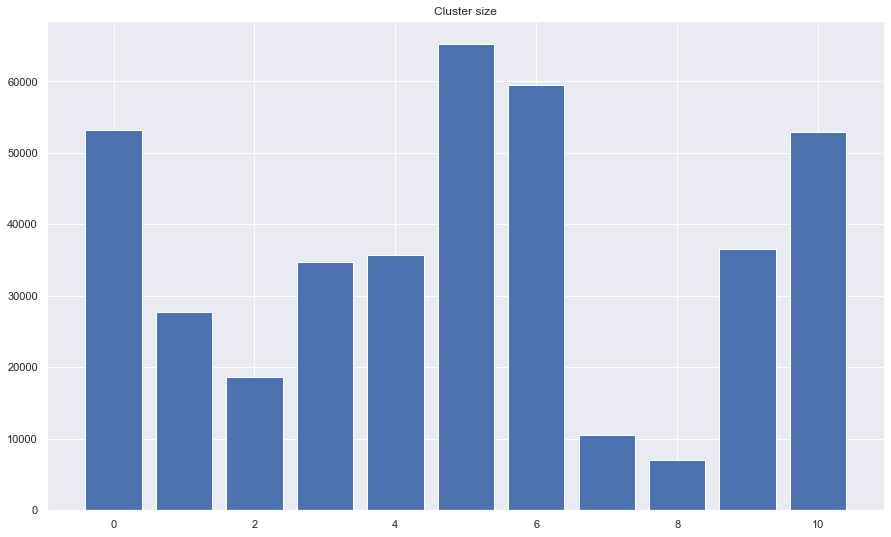

In [24]:
sns.set()
plt.figure(figsize = (15,9))
plt.bar(clust_size['cluster'], clust_size['count_rides'])
plt.title('Cluster size')
plt.show()

We will now create a pivot table where the columns are the regions, the value in the columns is the number of pickups in that region at the given time in the row.

In [25]:
df_crosstab = pd.pivot_table(rides_df, values = 'occupancy', index= 'pickup_time', columns ='cluster', aggfunc = 'sum')

In [31]:
df_crosstab = df_crosstab.replace(np.nan, 0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [431]:
region  = 10
ts_one  = pd.Series(df_crosstab[region]).reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [432]:
ts_one['weekday'] = ts_one['pickup_time'].dt.day_name()
ts_one['hour_of_day'] = ts_one['pickup_time'].dt.hour
ts_one['minute_of_day'] = ts_one['pickup_time'].dt.minute
ts_one = ts_one.rename(columns = {ts_one.columns[1]: 'zone'})
ts_one['previous_demand'] = ts_one['zone'].shift(1)
#ts_one.loc[ts_one["zone"] > 0, 'zone'] = 1
#ts_one['zone'] = ts_one['zone'].astype('category')
ts_one['weekday'] = ts_one['weekday'].astype('category')
ts_one['previous_demand'] = ts_one['previous_demand'].replace(np.nan, 0)
ts_one['week'] = ts_one['pickup_time'].dt.week

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


In [433]:
ts_one.head()

,pickup_time,zone,weekday,hour_of_day,minute_of_day,previous_demand,week
0,2008-05-17 12:00:04,0.0,Saturday,12,0,0.0,20
1,2008-05-17 12:00:05,1.0,Saturday,12,0,0.0,20
2,2008-05-17 12:00:07,0.0,Saturday,12,0,1.0,20
3,2008-05-17 12:00:08,0.0,Saturday,12,0,0.0,20
4,2008-05-17 12:00:09,0.0,Saturday,12,0,0.0,20


In [434]:
ts_hour = ts_one.groupby(['weekday','hour_of_day','minute_of_day','week'])['zone'].agg(np.sum).reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [435]:
ts_hour.shape, ts_one.shape

((50400, 5), (350332, 7))

In [436]:
ts_hour.loc[ts_hour["zone"] > 0, 'zone'] = 1
ts_hour['zone'] = ts_hour['zone'].astype('category')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


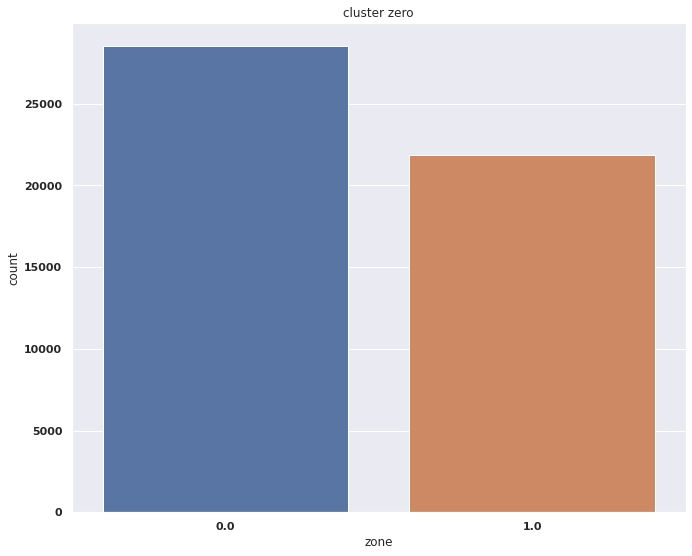

In [437]:
plt.figure(figsize = (11,9))
#plt.rcParams.update({'font.size': 30})
sns.countplot(x = ts_hour['zone'], data = ts_hour)
plt.title('cluster zero')
plt.show()

In [438]:
ts_hour.groupby('zone')['zone'].count()

zone
0.0    28511
1.0    21889
Name: zone, dtype: int64

In [439]:
ts_hour = pd.get_dummies(data = ts_hour, columns = ['weekday'], dtype= int)

In [440]:
ts_hour.dtypes

hour_of_day             int64
minute_of_day           int64
week                    int64
zone                 category
weekday_Friday          int32
weekday_Monday          int32
weekday_Saturday        int32
weekday_Sunday          int32
weekday_Thursday        int32
weekday_Tuesday         int32
weekday_Wednesday       int32
dtype: object

In [441]:
ts_one = ts_one.set_index('pickup_time')
ts_one = ts_one.sort_index()

In [442]:
ts_hour.head()

,hour_of_day,minute_of_day,week,zone,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0,0,20,0.0,1,0,0,0,0,0,0
1,0,0,21,0.0,1,0,0,0,0,0,0
2,0,0,22,0.0,1,0,0,0,0,0,0
3,0,0,23,1.0,1,0,0,0,0,0,0
4,0,0,24,0.0,1,0,0,0,0,0,0


<h3 id="Train-test split">Train-test split</h3>

In [443]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(ts_hour.loc[:, ~ts_hour.columns.isin(['zone'])], ts_hour['zone'], test_size=0.1,  stratify=ts_hour['zone'], random_state = 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<h2 id="Model-Training">Model-Training</h2>

<h3 id="LSTM">LSTM</h3>

Model as a Sequence Problem

In [444]:
x_reshape_train = x_train.values.reshape(x_train.shape[0],1,  x_train.shape[1]) 
x_reshape_test = x_test.values.reshape(x_test.shape[0], 1,  x_test.shape[1]) 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [445]:
input_shape=(x_reshape_train.shape[1:])

In [446]:
x_reshape_train.shape

(45360, 1, 10)

In [447]:
input_shape

(1, 10)

In [448]:
y_train=to_categorical(y_train)
y_test2=to_categorical(y_test)

In [449]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [480]:
def build_model():
    model = Sequential()
    model.add(LSTM(32, activation='sigmoid', input_shape=input_shape, stateful=False))
    model.add(Dense(32))
    #model.add(Dense(32, kernel_regularizer=regularizers.l1_l2(0.3)))
    #model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer= "adam", metrics=['acc',f1_m,precision_m, recall_m])
    return model
model_lstm=build_model()

In [481]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=5)
history_lstm = model_lstm.fit(x_reshape_train, y_train, epochs=10,batch_size=1,validation_data=(x_reshape_test, y_test2),shuffle=False)

Train on 45360 samples, validate on 5040 samples
Epoch 1/10
45360/45360 [==============================] - 102s 2ms/sample - loss: 0.6446 - acc: 0.6278 - f1_m: 0.6278 - precision_m: 0.6278 - recall_m: 0.6278 - val_loss: 0.6335 - val_acc: 0.6409 - val_f1_m: 0.6409 - val_precision_m: 0.6409 - val_recall_m: 0.6409
Epoch 2/10
45360/45360 [==============================] - 103s 2ms/sample - loss: 0.6260 - acc: 0.6513 - f1_m: 0.6513 - precision_m: 0.6513 - recall_m: 0.6513 - val_loss: 0.6270 - val_acc: 0.6425 - val_f1_m: 0.6425 - val_precision_m: 0.6425 - val_recall_m: 0.6425
Epoch 3/10
45360/45360 [==============================] - 118s 3ms/sample - loss: 0.6190 - acc: 0.6560 - f1_m: 0.6560 - precision_m: 0.6560 - recall_m: 0.6560 - val_loss: 0.6226 - val_acc: 0.6486 - val_f1_m: 0.6486 - val_precision_m: 0.6486 - val_recall_m: 0.6486
Epoch 4/10
45360/45360 [==============================] - 100s 2ms/sample - loss: 0.6143 - acc: 0.6587 - f1_m: 0.6587 - precision_m: 0.6587 - recall_m: 0.6587 

In [482]:
y_pred = model_lstm.predict(x_reshape_test)

In [483]:
preds3=[ 1 if i<j else 0 for i,j in y_pred] 

In [484]:
sum(preds3)

1837

In [485]:
sum(preds3)

1837

In [486]:
print(confusion_matrix(y_test, preds3))
print(classification_report(y_test, preds3))

[[2200  651]
 [1003 1186]]
              precision    recall  f1-score   support

         0.0       0.69      0.77      0.73      2851
         1.0       0.65      0.54      0.59      2189

    accuracy                           0.67      5040
   macro avg       0.67      0.66      0.66      5040
weighted avg       0.67      0.67      0.67      5040



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'ROC Curve')

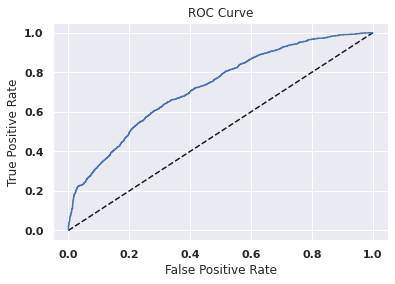

In [487]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test,  y_pred[:,1])

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [488]:
print(roc_auc_score(y_test, y_pred[:,1]))

0.7243469988570448


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
